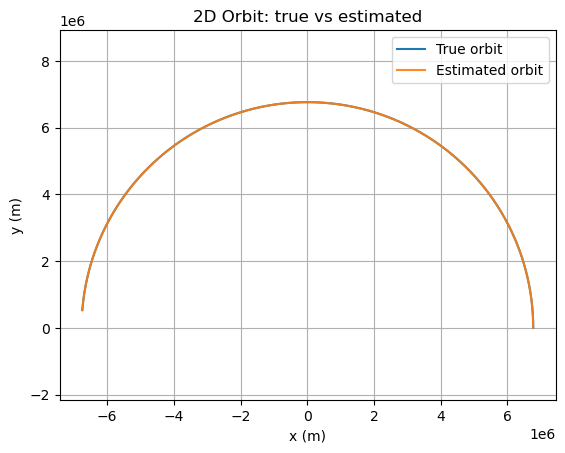

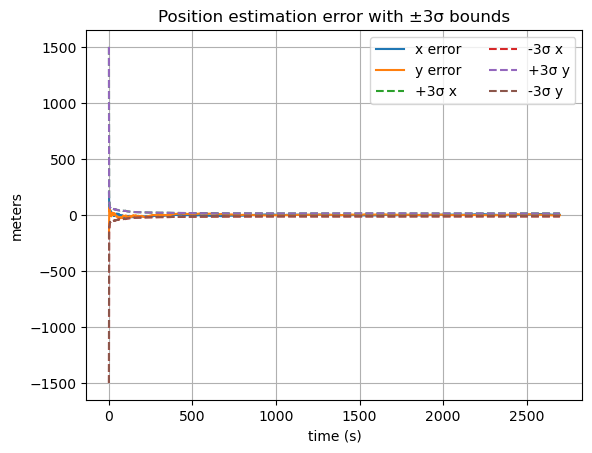

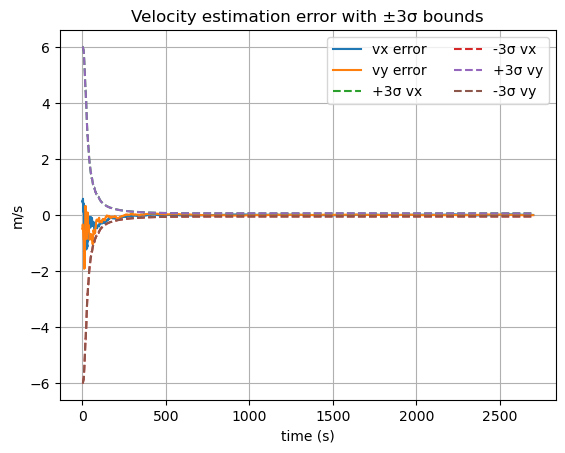

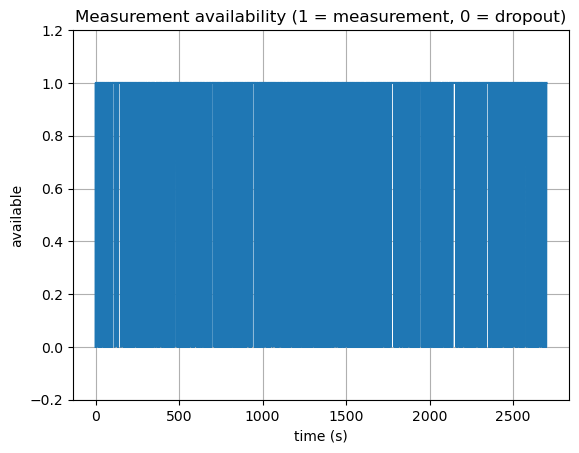

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helpers: dynamics + RK4
# ----------------------------
def two_body_accel(mu, r):
    x, y = r
    rho = np.sqrt(x*x + y*y)
    return -mu * np.array([x, y]) / (rho**3)

def f_continuous(mu, state):
    x, y, vx, vy = state
    ax, ay = two_body_accel(mu, np.array([x, y]))
    return np.array([vx, vy, ax, ay])

def rk4_step(mu, state, dt):
    k1 = f_continuous(mu, state)
    k2 = f_continuous(mu, state + 0.5 * dt * k1)
    k3 = f_continuous(mu, state + 0.5 * dt * k2)
    k4 = f_continuous(mu, state + dt * k3)
    return state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def jacobian_A(mu, state):
    """
    Continuous-time Jacobian A = df/dx for state [x, y, vx, vy].
    f = [vx, vy, ax(x,y), ay(x,y)]
    """
    x, y, vx, vy = state
    r2 = x*x + y*y
    r = np.sqrt(r2)
    r5 = r2 * r2 * r

    # Partial derivatives of acceleration:
    # a = -mu * r / r^3 = -mu * [x, y] / r^3
    # da/dx = -mu*( 1/r^3 - 3x^2/r^5 ), da/dy =  3mu*x*y/r^5 
    dadr = np.zeros((2, 2))
    dadr[0, 0] = -mu * (1.0 / (r**3) - 3.0 * x*x / r5)
    dadr[0, 1] =  3.0 * mu * x*y / r5
    dadr[1, 0] =  3.0 * mu * x*y / r5
    dadr[1, 1] = -mu * (1.0 / (r**3) - 3.0 * y*y / r5)

    A = np.zeros((4, 4))
    A[0, 2] = 1.0
    A[1, 3] = 1.0
    A[2, 0] = dadr[0, 0]
    A[2, 1] = dadr[0, 1]
    A[3, 0] = dadr[1, 0]
    A[3, 1] = dadr[1, 1]
    return A

# ----------------------------
# Simulation + EKF
# ----------------------------
def run_orbit_ekf():
    np.random.seed(7)

    # "Earth-ish" mu, 
    mu = 3.986004418e14  # m^3/s^2

    dt = 1.0             # seconds
    T = 60 * 45          # 45 minutes
    N = int(T / dt)

    # True initial orbit (rough LEO)
    r0 = np.array([6771e3, 0.0])        # meters
    v0 = np.array([0.0, 7670.0])        # m/s (close to circular)
    x_true = np.hstack([r0, v0])

    # Measurement model: z = [x, y] + noise
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])

    sigma_pos = 50.0  # meters measurement noise (std)
    R = (sigma_pos**2) * np.eye(2)

    # Process noise: small acceleration uncertainty (modeling errors)
    # We'll inject it via continuous white accel -> discrete Q approximation.
    sigma_a = 1e-3  # m/s^2 (tune this)
    q = sigma_a**2

    # Discrete process noise for constant-accel model mapping into [x,y,vx,vy]
    # Q ≈ q * [[dt^4/4 I, dt^3/2 I],
    #          [dt^3/2 I, dt^2   I]]
    I2 = np.eye(2)
    Q = q * np.block([
        [(dt**4)/4 * I2, (dt**3)/2 * I2],
        [(dt**3)/2 * I2, (dt**2)   * I2],
    ])

    # Measurement dropouts
    p_drop = 0.25  # 25% chance a measurement is missing each step

    # EKF initial guess (slightly wrong)
    x_hat = x_true + np.array([200.0, -200.0, 0.5, -0.5])
    P = np.diag([500.0**2, 500.0**2, 2.0**2, 2.0**2])

    # Storage
    X_true = np.zeros((N, 4))
    X_hat  = np.zeros((N, 4))
    Z_meas = np.full((N, 2), np.nan)
    used_meas = np.zeros(N, dtype=bool)
    sig3 = np.zeros((N, 4))

    for k in range(N):
        # ---- True propagation
        x_true = rk4_step(mu, x_true, dt)

        # ---- Measurement (sometimes missing)
        if np.random.rand() > p_drop:
            z = H @ x_true + np.random.randn(2) * sigma_pos
            Z_meas[k] = z
            used_meas[k] = True

        # ---- EKF predict
        x_pred = rk4_step(mu, x_hat, dt)

        # Linearize about predicted state (continuous A), then discretize (simple)
        A = jacobian_A(mu, x_pred)
        F = np.eye(4) + A * dt  # 1st-order discretization

        P_pred = F @ P @ F.T + Q

        # ---- EKF update (if measurement present)
        if used_meas[k]:
            z = Z_meas[k]
            y = z - (H @ x_pred)                 
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)     # Kalman gain
            x_hat = x_pred + K @ y
            P = (np.eye(4) - K @ H) @ P_pred
        else:
            x_hat = x_pred
            P = P_pred

        # Store
        X_true[k] = x_true
        X_hat[k]  = x_hat
        sig3[k]   = 3.0 * np.sqrt(np.diag(P))

    # ----------------------------
    # Plots
    # ----------------------------
    t = np.arange(N) * dt
    err = X_hat - X_true

    plt.figure()
    plt.plot(X_true[:, 0], X_true[:, 1], label="True orbit")
    plt.plot(X_hat[:, 0],  X_hat[:, 1],  label="Estimated orbit", alpha=0.9)
    plt.axis("equal")
    plt.grid(True)
    plt.title("2D Orbit: true vs estimated")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()

    plt.figure()
    plt.plot(t, err[:, 0], label="x error")
    plt.plot(t, err[:, 1], label="y error")
    plt.plot(t, sig3[:, 0], "--", label="+3σ x")
    plt.plot(t, -sig3[:, 0], "--", label="-3σ x")
    plt.plot(t, sig3[:, 1], "--", label="+3σ y")
    plt.plot(t, -sig3[:, 1], "--", label="-3σ y")
    plt.grid(True)
    plt.title("Position estimation error with ±3σ bounds")
    plt.xlabel("time (s)")
    plt.ylabel("meters")
    plt.legend(ncol=2)

    plt.figure()
    plt.plot(t, err[:, 2], label="vx error")
    plt.plot(t, err[:, 3], label="vy error")
    plt.plot(t, sig3[:, 2], "--", label="+3σ vx")
    plt.plot(t, -sig3[:, 2], "--", label="-3σ vx")
    plt.plot(t, sig3[:, 3], "--", label="+3σ vy")
    plt.plot(t, -sig3[:, 3], "--", label="-3σ vy")
    plt.grid(True)
    plt.title("Velocity estimation error with ±3σ bounds")
    plt.xlabel("time (s)")
    plt.ylabel("m/s")
    plt.legend(ncol=2)

    plt.figure()
    plt.plot(t, used_meas.astype(int))
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.title("Measurement availability (1 = measurement, 0 = dropout)")
    plt.xlabel("time (s)")
    plt.ylabel("available")

    plt.show()

if __name__ == "__main__":
    run_orbit_ekf()